## Preparing the business table as the basis for the work.

As a first approach to this database we must know and prepare the business table in order to be able to undertake further steps. For each business there are columns that contain a single value and others that have data in the form of a list or dictionary. We will make transformations that will allow us to make these columns much more useful. 
We will try to make sense of the geographical dimension by introducing metropolitan areas.

The database website (https://www.yelp.com/dataset) indicates that this data corresponds to 11 metropolitan areas. Using the geospatial data, we will determine and add this hidden variable to our business table.

Having observed the heterogeneity of the data, and from the previous literature review, we decided to focus our study on the most numerous business category, RESTAURANTS.

CHALLENGES:
- Handling json data, with nested fields.
- Change to parquet format.



In [ ]:
import pandas as pd
import numpy as np
import json
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import datetime as dt

In [ ]:
from psutil import virtual_memory
print(f'Working with {round(virtual_memory().total / 1e9,2)} gigas of RAM.')


Trabajando con 27.33 gigas de RAM.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/yelp/notebooks')

In [ ]:
business_json_path = r"../data/yelp_academic_dataset_business.json"
data_bus = pd.read_json(business_json_path, lines=True)

### 1. First steps: basic inspection of the table.
We have the data of 150.346 businesses.
We have complete data for id, name, city state, postal_code, latitude, loguitude, stars, review_count, is_open and categories. 
There are businesses missing data for categories, attributes and hours.

The data is not in tydi format, there are at least three fields to review and edit:

 * Attributes: Where for a heterogeneous set of characteristics is classified with True or False. Example: Accepts cards, has parking, etc.

 * Categories: A business can fall into several categories, e.g.: Restaurants, Food, Bubble Tea, Coffee & Tea. 

 * Hours: The opening days are given as a dictionary with key the day of the week and as a value with format '7:0-20:0' the opening hours of the shop.



 


In [ ]:
data_bus.shape

(150346, 14)

In [ ]:
data_bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


In [ ]:
data_bus.head(3)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."


In [ ]:
# Co-prove Nans.
data_bus.isna().sum().sum()

37070

In [ ]:
# Check for duplicate rows in all values.
data_bus[['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open','categories'
       ]].duplicated().any()

False

### 2. Cleaning of Nans.
As there are connections to all tables we are not going to delete anything.
We will mark them with a format similar to that of the records that have content, but with labels that let us know that they do not contain data.

categories: 'Sin_categoria'
attributes: {'Sin_atributos':True}

hours: {'Monday': 'ND:ND',
 'Tuesday': 'ND-ND',
 'Wednesday': 'ND-ND',
 'Thursday': 'ND-ND',
 'Friday': 'ND-ND',
 'Saturday': 'ND-ND',
 'Sunday': 'ND-ND'}



In [ ]:
colums_with_nans = [column for column in data_bus.columns if  data_bus[column].isna().sum()>0]
data_bus[colums_with_nans].isna().sum()

attributes    13744
categories      103
hours         23223
dtype: int64

In [ ]:
sin_horario = {'Monday': 'ND:ND',
 'Tuesday': 'ND-ND',
 'Wednesday': 'ND-ND',
 'Thursday': 'ND-ND',
 'Friday': 'ND-ND',
 'Saturday': 'ND-ND',
 'Sunday': 'ND-ND'}

data_bus['categories'] = data_bus['categories'].fillna('Sin_categoria')
data_bus['attributes'] = data_bus['attributes'].fillna({'Sin_atributos':True})
data_bus['hours'] = data_bus['hours'].fillna(sin_horario)

## 3- Business situation. Metropolitan area.
We present a complete series of maps and tables that allow us to observe the geographical distribution of businesses, from states to the starting grouping of this database, metropolitan area, a field that we will create.

In [ ]:
print(f'Existen negocios de {data_bus.state.nunique()} estados diferentes.')
print(f'Existen negocios de {data_bus.city.nunique()} ciudades diferentes.')

Existen negocios de 27 estados diferentes.
Existen negocios de 1416 ciudades diferentes.


We generate a table that allows us to observe how businesses are distributed among the states, as there are cities in 11 states that concentrate a high number of businesses (head of the metropolitan area). We will use this table as a basis for geospatial visualisations, which will allow us to make a very detailed study of the business data we have at hand.

In [ ]:
# Generate a dataframe that allows us to see in which states we have businesses located.
business_per_state = data_bus.state.value_counts().to_frame().rename(columns = {'state':'business_state'})
business_per_state['perc'] = data_bus.state.value_counts(normalize=True)
business_per_state['perc_acum'] = business_per_state['perc'].cumsum()
business_per_state = business_per_state.reset_index().rename(columns = {'index':'state'})
# Generate a dataframe with the revisions by state.
rew_states = data_bus[['state','review_count']].groupby(['state']).sum()
# Generate a dataframe with the number of unique cities per state.
cities_by_state = data_bus[['state','city']].groupby(['state'])['city'].nunique().to_frame()

# Build our state-by-state summary dataframe.
states_df = business_per_state.set_index('state').join(cities_by_state)
states_df = states_df.join(rew_states)
first_city = (data_bus[['state','city','business_id']].groupby(['state','city']).count().reset_index().
                                          sort_values(by = 'business_id',ascending=False).
                                          drop_duplicates(subset = 'state',keep = 'first').
                                          rename(columns = {'city':'first_city','business_id':'firt_city_mumber_buss'}).
                                          set_index('state'))
states_df = states_df.join(first_city)



states_df = states_df.reset_index()
states_df

,state,business_state,perc,perc_acum,city,review_count,first_city,firt_city_mumber_buss
0,PA,34039,0.226404,0.226404,434,1540790,Philadelphia,14567
1,FL,26330,0.175129,0.401534,226,1119926,Tampa,9048
2,TN,12056,0.080188,0.481722,72,598195,Nashville,6968
3,IN,11247,0.074807,0.556530,58,472565,Indianapolis,7540
4,MO,10913,0.072586,0.629116,117,483897,Saint Louis,4827
5,LA,9924,0.066008,0.695123,53,743176,New Orleans,6208
6,AZ,9912,0.065928,0.761051,34,412639,Tucson,9249
7,NJ,8536,0.056776,0.817827,239,249837,Cherry Hill,959
8,NV,7715,0.051315,0.869142,31,409950,Reno,5932
9,AB,5573,0.037068,0.906210,24,105477,Edmonton,5054


We will generate several visualisations that lead us to conclude that we are being given business data from several metropolitan areas, a central city and surrounding cities. We will call this dimension a metropolitan area.
Within a metropolitan area there can be cities in different states, as we will see.

### States:
We are going to do a visulaisation by states. When passing through each state, labels with relevant data are shown.

In [ ]:
# Download map of the US by state.
url = ("https://raw.githubusercontent.com/python-visualization/folium/master/examples/data")
state_geo = f"{url}/us-states.json"

states_df_plot=states_df


f = folium.Figure(width=1000, height=500)
m = folium.Map(location=[39, -97], zoom_start=4.35).add_to(f)

cp = folium.Choropleth(
    geo_data = state_geo,
    name = "choropleth",
    data = states_df,
    columns = ["state", "business_state"],
    key_on = "feature.id",
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    nan_fill_opacity = 0,
    line_opacity = 0.2,
    legend_name = "Negocios",
).add_to(m)

# creating a state indexed version of the dataframe so we can lookup values
states_df_indexed = states_df.set_index('state')

# looping thru the geojson object and adding a new property(unemployment)
# and assigning a value from our dataframe
for s in cp.geojson.data['features']:
    if s['id'] in states_df['state'].tolist():
      s['properties']["business_state"] = int(states_df.set_index('state').loc[s['id'], "business_state"])
      s['properties']["num_cities"] = int(states_df.set_index('state').loc[s['id'], "city"])
      s['properties']["review_count"] = int(states_df.set_index('state').loc[s['id'], "review_count"])
      
    else:
      s['properties']["business_state"] = 0
      s['properties']["num_cities"] = 0
      s['properties']["review_count"] = 0
      
# and finally adding a tooltip/hover to the choropleth's geojson
folium.GeoJsonTooltip(['name', "business_state","num_cities",'review_count']).add_to(cp.geojson)

folium.LayerControl().add_to(m)

m

Number of city listed 1416


Text(0.5, 1.0, 'Top city business listed in Yelp')

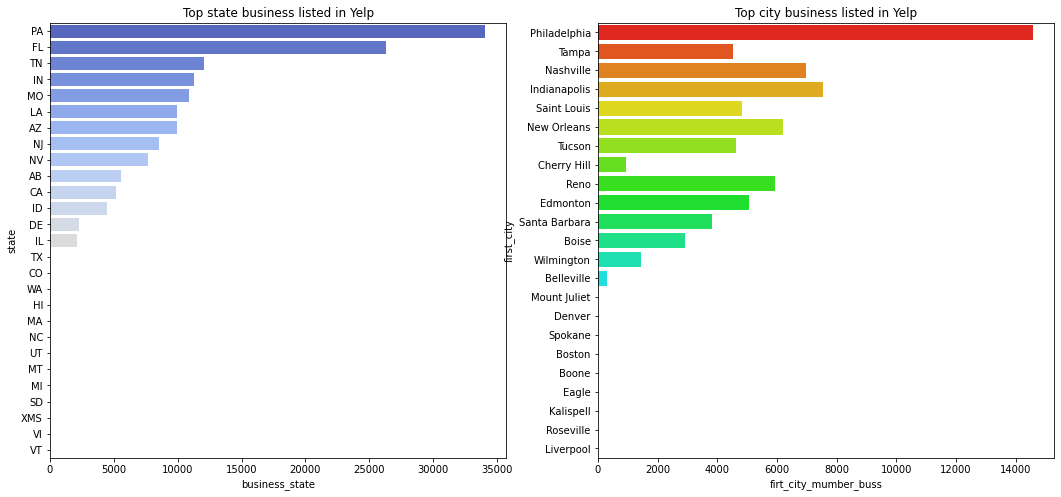

In [ ]:
print('Number of city listed',data_bus['city'].nunique())
f,ax = plt.subplots(1,2, figsize=(18,8))
ax1,ax2, = ax.flatten()

sns.barplot(data = states_df, x = 'business_state', y = 'state', palette = 'coolwarm', ax = ax1)
ax1.set_title('Top state business listed in Yelp');

sns.barplot(data = states_df.iloc[0:25], x = 'firt_city_mumber_buss', y = 'first_city', ci = None, palette = 'gist_rainbow', ax = ax2)
ax2.set_title('Top city business listed in Yelp')


### Cities

By making a one-point graph by city name, you can see very well what is being offered in this version of the database. These are the metropolitan area data for ten American cities and one Canadian city. Philadelpia, Tampa, New Orleans, Nashville, Saint Louis, Tucson, Reno, Boise, Santa Barbara, Indianapolis and Entomton in Canada.
There are metropolitan areas that are located in more than one state, Philadelphia, St. Louis, Boise, which together with some duplicity in place names, give us these states with very few revisions.

In [ ]:
df_city_unique=data_bus.drop_duplicates(subset='city',keep=False)

Locations = list(zip(df_city_unique.latitude, df_city_unique.longitude))

f = folium.Figure(width = 1000, height = 500)
dcmap =  folium.Map(location = [48, -102], zoom_start = 4).add_to(f)

for loc in Locations:
   markers = folium.CircleMarker(location=loc,radius=6,fill=True, fill_opacity=1)
   dcmap.add_child(markers)

#Set the zoom to the maximum possible
dcmap.fit_bounds(f.get_bounds())

dcmap


In [ ]:
cabezeras_city = ['Philadelphia','Tucson','Tampa','Indianapolis','Nashville','New Orleans','Reno','Edmonton',
'Saint Louis','Santa Barbara','Boise']
cabezeras_df = data_bus[['city','longitude','latitude','postal_code']][data_bus.city.isin(cabezeras_city)].drop_duplicates(subset='city',keep="first").set_index('city')


In [ ]:
cabezeras_df

,longitude,latitude,postal_code
city,,,
Santa Barbara,-119.711197,34.426679,93101
Tucson,-110.880452,32.223236,85711
Philadelphia,-75.155564,39.955505,19107
Nashville,-86.768170,36.208102,37207
Indianapolis,-86.127217,39.637133,46227
New Orleans,-90.129953,29.941468,70118
Edmonton,-113.499169,53.546045,T5J 1B9
Reno,-119.789339,39.476117,89502
Boise,-116.285382,43.616763,83704


### Metro_area. Discovering hidden characteristics.

We are interested in constructing a feature that groups the data into these 11 areas.
We do this by assigning each business the area header to the one with the least distance. It works very well for us.

In [ ]:
import geopy.distance
def metro_area(lat,lon):
  # Given a lat-log pair, it will return the nearest metrohead.
  fixed_coords = (lat, lon)

  cabezeras_df['distance'] = cabezeras_df.apply(
      lambda row: geopy.distance.distance((row.latitude, row.longitude), fixed_coords).km,axis=1)
  return cabezeras_df.distance.idxmin()

In [ ]:
# Apply the created function to the whole dataset, slow 5 minutes, but it does it correctly.
data_bus['metro_area'] = data_bus[['latitude','longitude']].apply(lambda row1: metro_area(row1.latitude,row1.longitude),axis=1)

In [ ]:
# Save to disk.
data_bus.to_parquet("../data/business/yelp_business.parquet",
              compression='gzip')

In [ ]:
data_bus = pd.read_parquet("../data/business/yelp_business.parquet")

In [ ]:
data_bus.metro_area.value_counts().to_frame()

,metro_area
Philadelphia,44847
Tampa,26336
Saint Louis,13063
Nashville,12058
Indianapolis,11248
New Orleans,9925
Tucson,9916
Reno,7732
Edmonton,5573
Santa Barbara,5177


By changing the variable metro_to_plot, any metropolitan area can be visualised. Very visual.
You can see the commercial zones perfectly in all areas.
You can see concentrations of businesses in the famous malls, shopping centres.

In [ ]:
metro_to_plot = 'Tampa'

df_f = data_bus[data_bus.metro_area == metro_to_plot]
Locations = list(zip(df_f.latitude, df_f.longitude))

f = folium.Figure(width = 1500, height = 750)


dcmap = folium.Map(location = [48, -102], zoom_start = 3).add_to(f)

for loc in Locations:
   markers = folium.CircleMarker(location=loc,radius = 1, fill = True, fill_opacity = 1)
   dcmap.add_child(markers)
dcmap.fit_bounds(f.get_bounds())
dcmap

Output hidden; open in https://colab.research.google.com to view.

### Preparation of categories.

The table "business" includes each "category". This column contains a list of categories that apply to the business in question. Categories are labels that are used to describe the type of business or the type of products or services it offers. For example, a pizzeria could have the categories "fast food", "pizzeria" and "restaurants". These categories are used to classify and organise businesses in the Yelp database, and can also be used by users of the application to find specific businesses.

We will keep the first 12 categories for each business. There is a maximum of 36 categories in any one business. But by keeping the first 12 we will be collecting all the categories of 99.47% of the businesses.

We will generate 12 columns from category_1 to category_12, and we will dispense with categories.

We will transform the categories into a numerical code in a very precise way. WE WILL ASSIGN THE LOWEST VALUES TO THE MOST FREQUENT CATEGORIES. So that in later steps, it will allow us to DISCRIMINATE BUSINESSES, BY THE SPECIFICITY OF THEIR OFFERING. Thus a business, which only includes "restaurants" and "food", two of the most frequent categories, will have a very generic presentation, adding the word "spanish", its presentation will be much more precise. We have not found this approach in the works published on yelp dataset, so we consider it a novelty in the analysis of this database.


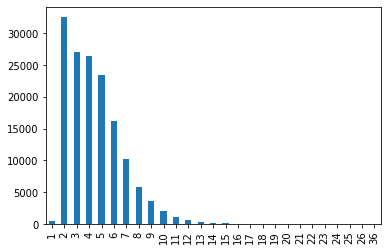

In [ ]:
# Distribution of businesses by number of labels present.
data_bus.categories.apply(lambda x: len(x.split(','))).value_counts(normalize=False).sort_index().plot(kind='bar')

In [ ]:
#Coverage demonstration with 12 cartegories.
data_bus.categories.apply(lambda x: len(x.split(','))).value_counts(normalize=True).sort_index().cumsum().head(12)

1     0.003219
2     0.219806
3     0.399824
4     0.575113
5     0.731087
6     0.839058
7     0.906828
8     0.945865
9     0.969796
10    0.983259
11    0.990462
12    0.994765
Name: categories, dtype: float64

In [ ]:
# list for column names.
categories_columns = ['category_1', 'category_2', 'category_3', 'category_4', 'category_5', 
                             'category_6', 'category_7', 'category_8', 'category_9', 'category_10','category_11','category_12']



In [ ]:
# categories column has many categories at once. Let's split the categories column and store each category in it's own column
df_category_split = data_bus['categories'].str.split(',', expand=True)[[0,1,2,3,4,5,6,7,8,9,10,11]]
# rename the new columns
df_category_split.columns = ['category_1', 'category_2', 'category_3', 'category_4', 'category_5', 
                             'category_6', 'category_7', 'category_8', 'category_9', 'category_10','category_11','category_12']
data_bus = pd.concat([data_bus, df_category_split], axis=1)
# now drop the actual categories column
data_bus = data_bus.drop(['categories'], axis=1)
data_bus.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_11,category_12
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,Naturopathic/Holistic,Acupuncture,Health & Medical,Nutritionists,None,None,None,None,None,None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,...,Notaries,Mailbox Centers,Printing Services,None,None,None,None,None,None,None
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,...,Fashion,Home & Garden,Electronics,Furniture Stores,None,None,None,None,None,None
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,Bubble Tea,Coffee & Tea,Bakeries,None,None,None,None,None,None,None
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,...,Food,None,None,None,None,None,None,None,None,None


In [ ]:
# Make sure that the categories do not contain blank spaces.

data_bus[categories_columns] = data_bus[categories_columns].apply(lambda x: x.str.strip())

In [ ]:
# Generate a frame by stacking all categories in a single column sorted by category.
categories_frame = data_bus[categories_columns].unstack().reset_index().drop(columns=['level_0','level_1']).value_counts(normalize=False).to_frame()
categories_frame = categories_frame.rename(columns={0:'number'}).reset_index().rename(columns={0:'category'})


There are 1311 different business categories. Restaurants are the most frequent, followed by food and shopping, domestic services and beauty. Hospitality related activities are the most common categories, restaurants, nightlife, bars, Sandwiches, American (Traditional), Pizza.

In [ ]:
categories_frame.head(15)

,category,number
0,Restaurants,52217
1,Food,27735
2,Shopping,24325
3,Home Services,14338
4,Beauty & Spas,14275
5,Nightlife,12242
6,Health & Medical,11874
7,Local Services,11175
8,Bars,11020
9,Automotive,10766


In [ ]:
# Fill with no_disp the business columns that contain less than 12 categories.
data_bus[categories_columns] = data_bus[categories_columns].fillna('no_disp')

In [ ]:
data_bus[categories_columns].isna().sum().sum()

0

Let's configure our categories dataset. The order is key, we want to keep it, assigning the lowest code to the most present, more generic categories, and the highest order to the categories with the most occurrences, more specific.


In [ ]:
# Generate a dictionary with the index, which is sorted from highest to lowest number of occurrences and their business.
categories_map = categories_frame['category'].to_dict()

In [ ]:
for key in sorted(categories_map)[:10]:
    print (key, categories_map[key])

0 Restaurants
1 Food
2 Shopping
3 Home Services
4 Beauty & Spas
5 Nightlife
6 Health & Medical
7 Local Services
8 Bars
9 Automotive


In [ ]:
for key in sorted(categories_map)[-10:]:
    print (key, categories_map[key])

1301 Halfway Houses
1302 Storefront Clinics
1303 Stonemasons
1304 Metal Detector Services
1305 Housing Cooperatives
1306 Pathologists
1307 Ceremonial Clothing
1308 Sport Equipment Hire
1309 Interlock Systems
1310 Calabrian


In [ ]:
# Exchange the key and the value to have the business description as the key.
categories_map = {v: k for k, v in categories_map.items()}

In [ ]:
# first 10 dictionary elements by code.
{ key:value for (key,value) in categories_map.items() if value <= 10}

{'Restaurants': 0,
 'Food': 1,
 'Shopping': 2,
 'Home Services': 3,
 'Beauty & Spas': 4,
 'Nightlife': 5,
 'Health & Medical': 6,
 'Local Services': 7,
 'Bars': 8,
 'Automotive': 9,
 'Event Planning & Services': 10}

In [ ]:
# Transform our dictionary into a frame.
categories_df = pd.DataFrame.from_dict(categories_map,orient='index').rename(columns = {0:'codigo'})

In [ ]:
# add it to a file.
categories_df.to_parquet("../data/business/categories_df.parquet",
              compression='gzip')

In [ ]:
# map the category column of the data_buss table by the obtained code. 

for column in categories_columns:
  data_bus[column] = data_bus[column].map(categories_map)

# Assign the value 9999 to the no_disp and convert to int
data_bus[categories_columns]=data_bus[categories_columns].fillna(9999)
data_bus[categories_columns] = data_bus[categories_columns].astype(int)


In [ ]:
data_bus[categories_columns]

,category_1,category_2,category_3,category_4,category_5,category_6,category_7,category_8,category_9,category_10,category_11,category_12
0,31,432,388,254,6,247,9999,9999,9999,9999,9999,9999
1,161,7,218,288,163,9999,9999,9999,9999,9999,9999,9999
2,93,2,21,20,95,82,9999,9999,9999,9999,9999,9999
3,0,1,232,15,39,9999,9999,9999,9999,9999,9999,9999
4,419,147,1,9999,9999,9999,9999,9999,9999,9999,9999,9999
...,...,...,...,...,...,...,...,...,...,...,...,...
150341,26,4,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
150342,30,143,121,209,913,20,2,9999,9999,9999,9999,9999
150343,2,87,271,217,4,79,21,9999,9999,9999,9999,9999
150344,571,124,2,78,239,9999,9999,9999,9999,9999,9999,9999


In [ ]:
# Order the categories within each row so that the most important ones are at the top.
data_bus[categories_columns] = np.sort(data_bus[categories_columns].values,axis=1)


In [ ]:
# All restaurant categories have remained in category_1.
data_bus[categories_columns].agg([min,max]).T

,min,max
category_1,0,556
category_2,1,9999
category_3,2,9999
category_4,3,9999
category_5,5,9999
category_6,8,9999
category_7,11,9999
category_8,14,9999
category_9,18,9999
category_10,22,9999


## Attribute field preparation.
Organising the attributes is going to give us more work, they are in nested json format.  We will have to go key by key checking and cleaning up.

In [ ]:
# Generate a frame with the content of attributes.
atributos_df = pd.json_normalize(data_bus['attributes'])

In [ ]:
atributos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   AcceptsInsurance            5713 non-null    object
 1   AgesAllowed                 129 non-null     object
 2   Alcohol                     43189 non-null   object
 3   Ambience                    44279 non-null   object
 4   BYOB                        4451 non-null    object
 5   BYOBCorkage                 1444 non-null    object
 6   BestNights                  5694 non-null    object
 7   BikeParking                 72638 non-null   object
 8   BusinessAcceptsBitcoin      17430 non-null   object
 9   BusinessAcceptsCreditCards  119765 non-null  object
 10  BusinessParking             91085 non-null   object
 11  ByAppointmentOnly           42339 non-null   object
 12  Caters                      40127 non-null   object
 13  CoatCheck                   5

In [ ]:
# Mark as candidates for deletion those containing less than 6,000 valid data.
candidates_drop = [column for column in atributos_df.columns if  atributos_df[column].isna().sum()>atributos_df.shape[0]-6000]

In [ ]:
candidates_drop

['AcceptsInsurance',
 'AgesAllowed',
 'BYOB',
 'BYOBCorkage',
 'BestNights',
 'CoatCheck',
 'Corkage',
 'DietaryRestrictions',
 'GoodForDancing',
 'HairSpecializesIn',
 'Open24Hours',
 'RestaurantsCounterService',
 'Smoking']

In [ ]:
atributos_df = atributos_df.drop(candidates_drop, axis=1)

In [ ]:
# Generate list with the columns that are of type bool
amb_bool_type = ['BikeParking','BusinessAcceptsBitcoin','BusinessAcceptsCreditCards','BusinessParking','ByAppointmentOnly','Caters','DogsAllowed', 
 'DriveThru', 'GoodForKids','HappyHour','HasTV','Music','OutdoorSeating','RestaurantsDelivery','RestaurantsGoodForGroups','RestaurantsReservations',
 'RestaurantsTableService','RestaurantsTakeOut','WheelchairAccessible']


In [ ]:
# Generate list of non-bool columns.
amb_not_bool = ['Alcohol','Ambience','GoodForMeal','Music','NoiseLevel','RestaurantsAttire','RestaurantsPriceRange2','WiFi']

In [ ]:
# Fix the bool columns, replacing None with np.nan and filling with False.
for column in amb_bool_type:
  atributos_df[column] = atributos_df[column].replace(to_replace=['False',None,'None'], value=np.nan)
  atributos_df[column] = atributos_df[column].fillna(False)
  atributos_df[column] = atributos_df[column].astype(bool)

In [ ]:
atributos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Alcohol                     43189 non-null   object
 1   Ambience                    44279 non-null   object
 2   BikeParking                 150346 non-null  bool  
 3   BusinessAcceptsBitcoin      150346 non-null  bool  
 4   BusinessAcceptsCreditCards  150346 non-null  bool  
 5   BusinessParking             150346 non-null  bool  
 6   ByAppointmentOnly           150346 non-null  bool  
 7   Caters                      150346 non-null  bool  
 8   DogsAllowed                 150346 non-null  bool  
 9   DriveThru                   150346 non-null  bool  
 10  GoodForKids                 150346 non-null  bool  
 11  GoodForMeal                 29087 non-null   object
 12  HappyHour                   150346 non-null  bool  
 13  HasTV                       1

In [ ]:
# Fix Alcohol
atributos_df.Alcohol = atributos_df.Alcohol.str.lower().str.replace(r'^u\'|^\'|\'$','',regex=True)
atributos_df.Alcohol = atributos_df.Alcohol.fillna('no_disp')

In [ ]:
atributos_df.Alcohol.value_counts(dropna=False)

no_disp          107157
none              20948
full_bar          15992
beer_and_wine      6249
Name: Alcohol, dtype: int64

In [ ]:
# Fix Ambience.
# Replace None and 'None' with Nan. Then we set the NAns to a dictionary string with all False.
atributos_df.Ambience = atributos_df.Ambience.replace(to_replace=[None,'None'], value=np.nan)
atributos_df.Ambience = atributos_df.Ambience.fillna("""{'romantic': False, 'intimate': False, 'touristy': False,'hipster': False, 'divey':
                                                       False, 'classy': False, 'trendy': False,'upscale': False, 'casual': False}""")

In [ ]:
# We clean up malformed names and change '' to "".
atributos_df.Ambience = atributos_df.Ambience.str.replace("u'romantic'",'romantic')
atributos_df.Ambience = atributos_df.Ambience.str.replace("u'intimate'",'intimate')
atributos_df.Ambience = atributos_df.Ambience.str.replace("u'touristy'",'touristy')
atributos_df.Ambience = atributos_df.Ambience.str.replace("u'hipster'",'hipster')
atributos_df.Ambience =  atributos_df.Ambience.str.replace("u'divey'",'divey')
atributos_df.Ambience = atributos_df.Ambience.str.replace("u'classy'",'classy')
atributos_df.Ambience = atributos_df.Ambience.str.replace("u'classy'",'classy')
atributos_df.Ambience = atributos_df.Ambience.str.replace("u'trendy'",'trendy')
atributos_df.Ambience = atributos_df.Ambience.str.replace("u'upscale'",'upscale')
atributos_df.Ambience = atributos_df.Ambience.str.replace("u'casual'",'casual')
atributos_df.Ambience = atributos_df.Ambience.str.replace("'",'"')

In [ ]:
# Design a function to transform string into dictionary.
import ast
def perfectEval(anonstring):
  try:
    ev = ast.literal_eval(anonstring)
    return ev
  except ValueError:
    ev = {}
    return ev

In [ ]:
# Generate a frame just for the environments.
ambience_df = pd.json_normalize(atributos_df.Ambience.apply(perfectEval))
ambience_df = ambience_df.fillna(False)

In [ ]:
# Merge the two tables and delete the original column.
atributos_df = atributos_df.join(ambience_df)
atributos_df = atributos_df.drop(columns=['Ambience'])

In [ ]:
atributos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Alcohol                     150346 non-null  object
 1   BikeParking                 150346 non-null  bool  
 2   BusinessAcceptsBitcoin      150346 non-null  bool  
 3   BusinessAcceptsCreditCards  150346 non-null  bool  
 4   BusinessParking             150346 non-null  bool  
 5   ByAppointmentOnly           150346 non-null  bool  
 6   Caters                      150346 non-null  bool  
 7   DogsAllowed                 150346 non-null  bool  
 8   DriveThru                   150346 non-null  bool  
 9   GoodForKids                 150346 non-null  bool  
 10  GoodForMeal                 29087 non-null   object
 11  HappyHour                   150346 non-null  bool  
 12  HasTV                       150346 non-null  bool  
 13  Music                       1

In [ ]:
# Repeating Ambience's strategy with GoodForMeal.
atributos_df.GoodForMeal = atributos_df.GoodForMeal.replace(to_replace=[None,'None'], value=np.nan)
atributos_df.GoodForMeal = atributos_df.GoodForMeal.fillna("""{"dessert": False, "latenight": False, "lunch": False,"dinner": False, "brunch": False, "breakfast": False} """)

In [ ]:
atributos_df.GoodForMeal = atributos_df.GoodForMeal .str.replace("u'breakfast'",'breakfast')
atributos_df.GoodForMeal = atributos_df.GoodForMeal .str.replace("u'brunch'",'brunch')
atributos_df.GoodForMeal = atributos_df.GoodForMeal .str.replace("u'lunch'",'lunch')
atributos_df.GoodForMeal = atributos_df.GoodForMeal .str.replace("u'dinner'",'dinner')
atributos_df.GoodForMeal = atributos_df.GoodForMeal .str.replace("u'latenight'",'latenight')
atributos_df.GoodForMeal = atributos_df.GoodForMeal .str.replace("u'dessert'",'dessert')
atributos_df.GoodForMeal = atributos_df.GoodForMeal .str.replace("'",'"')

In [ ]:
# Create frame with transformation from string to dictionary
good_for_meal_df = pd.json_normalize(atributos_df.GoodForMeal.apply(perfectEval))
good_for_meal_df = good_for_meal_df.fillna(False)

In [ ]:
# Merge tables and delete the original column.
atributos_df = atributos_df.join(good_for_meal_df)
atributos_df = atributos_df.drop(columns=['GoodForMeal'])

In [ ]:
# Fix NoiseLevel.
atributos_df.NoiseLevel = atributos_df.NoiseLevel.str.lower().str.replace(r'^u\'|^\'|\'$','',regex=True)
atributos_df.NoiseLevel                                                                                                                          = atributos_df.NoiseLevel.fillna('no_disp')

In [ ]:
atributos_df.NoiseLevel.value_counts()


no_disp      112353
average       26188
quiet          7634
loud           2932
very_loud      1200
none             39
Name: NoiseLevel, dtype: int64

In [ ]:
# Fix RestaurantsAttire
atributos_df.RestaurantsAttire = atributos_df.RestaurantsAttire.str.lower().str.replace(r'^u\'|^\'|\'$','',regex=True)
atributos_df.RestaurantsAttire = atributos_df.RestaurantsAttire.fillna('no_disp')

In [ ]:
atributos_df.RestaurantsAttire.value_counts(dropna=False)

no_disp    111091
casual      38344
dressy        803
formal         70
none           38
Name: RestaurantsAttire, dtype: int64

In [ ]:
# Fix RestaurantsPriceRange2, asignd the 0 to the Nans.
atributos_df.RestaurantsPriceRange2 = atributos_df.RestaurantsPriceRange2.replace(to_replace=[None,'None'], value=np.nan)
atributos_df.RestaurantsPriceRange2 = atributos_df.RestaurantsPriceRange2.fillna(0)
atributos_df.RestaurantsPriceRange2 = atributos_df.RestaurantsPriceRange2.astype(int)

In [ ]:
atributos_df.RestaurantsPriceRange2.value_counts(dropna=False)

0    65066
2    48581
1    28840
3     6667
4     1192
Name: RestaurantsPriceRange2, dtype: int64

In [ ]:
# Arreglamos WiFi
atributos_df['WiFi'] = atributos_df['WiFi'].str.lower().str.replace(r'^u\'|^\'|\'$','',regex=True)
atributos_df['WiFi'] = atributos_df['WiFi'].fillna('no_disp')
atributos_df.loc[atributos_df['WiFi'] == 'none','WiFi'] = 'no'

In [ ]:

atributos_df.WiFi.value_counts(dropna=False)

no_disp    93432
free       34414
no         21881
paid         619
Name: WiFi, dtype: int64

We merge the attributes table with the data_bus table. We have finished cleaning up attributes.


In [ ]:
# Merge tables and delete original column
data_bus = data_bus.join(atributos_df)
data_bus = data_bus.drop(columns=['attributes'])

In [ ]:
data_bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 64 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   business_id                 150346 non-null  object 
 1   name                        150346 non-null  object 
 2   address                     150346 non-null  object 
 3   city                        150346 non-null  object 
 4   state                       150346 non-null  object 
 5   postal_code                 150346 non-null  object 
 6   latitude                    150346 non-null  float64
 7   longitude                   150346 non-null  float64
 8   stars                       150346 non-null  float64
 9   review_count                150346 non-null  int64  
 10  is_open                     150346 non-null  int64  
 11  hours                       127123 non-null  object 
 12  metro_area                  150346 non-null  object 
 13  category_1    

In [ ]:
data_bus.to_parquet("../data/business/business_expanded.parquet",
              compression='gzip')

In [ ]:
data_bus = pd.read_parquet("../data/business/business_expanded.parquet")

### Preparation hours field.

Finally we are going to transform the timetables, in order to keep the hours that are open each day of the week.

In [ ]:
hour_df = pd.json_normalize(data_bus['hours'])

In [ ]:
hour_df = hour_df.fillna('0:0-0:0')

In [ ]:
hour_df

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0
1,8:0-18:30,0:0-0:0,8:0-14:0,0:0-0:0,8:0-18:30,8:0-18:30,8:0-18:30
2,8:0-23:0,8:0-22:0,8:0-23:0,8:0-22:0,8:0-22:0,8:0-22:0,8:0-22:0
3,7:0-21:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-20:0,7:0-20:0,7:0-20:0
4,12:0-22:0,0:0-0:0,12:0-22:0,12:0-18:0,16:0-22:0,0:0-0:0,14:0-22:0
...,...,...,...,...,...,...,...
150341,10:0-19:30,10:0-19:30,10:0-17:30,11:0-17:0,10:0-19:30,10:0-19:30,10:0-19:30
150342,9:30-17:30,9:30-17:30,9:0-17:0,0:0-16:0,9:30-17:30,9:30-17:30,9:30-17:30
150343,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0,0:0-0:0
150344,9:0-20:0,9:0-20:0,9:0-17:0,10:0-17:0,9:0-20:0,9:0-20:0,9:0-20:0


In [ ]:
for column in hour_df.columns:
  open = column+'_open'
  close = column+'_close'
  day = hour_df[column].str.split('-', expand=True)
  day = day.rename(columns={0:open,1:close})
  hour_df = hour_df.join(day)


In [ ]:
hour_df = hour_df.drop(columns=['Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday'])

In [ ]:
def str2time(val):
    try:
        return dt.datetime.strptime(val, '%H:%M').time()
    except:
        return pd.NaT

In [ ]:
hour_df = hour_df.applymap(lambda x: str2time(x))

In [ ]:
hour_df

,Friday_open,Friday_close,Monday_open,Monday_close,Saturday_open,Saturday_close,Sunday_open,Sunday_close,Thursday_open,Thursday_close,Tuesday_open,Tuesday_close,Wednesday_open,Wednesday_close
0,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
1,08:00:00,18:30:00,00:00:00,00:00:00,08:00:00,14:00:00,00:00:00,00:00:00,08:00:00,18:30:00,08:00:00,18:30:00,08:00:00,18:30:00
2,08:00:00,23:00:00,08:00:00,22:00:00,08:00:00,23:00:00,08:00:00,22:00:00,08:00:00,22:00:00,08:00:00,22:00:00,08:00:00,22:00:00
3,07:00:00,21:00:00,07:00:00,20:00:00,07:00:00,21:00:00,07:00:00,21:00:00,07:00:00,20:00:00,07:00:00,20:00:00,07:00:00,20:00:00
4,12:00:00,22:00:00,00:00:00,00:00:00,12:00:00,22:00:00,12:00:00,18:00:00,16:00:00,22:00:00,00:00:00,00:00:00,14:00:00,22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150341,10:00:00,19:30:00,10:00:00,19:30:00,10:00:00,17:30:00,11:00:00,17:00:00,10:00:00,19:30:00,10:00:00,19:30:00,10:00:00,19:30:00
150342,09:30:00,17:30:00,09:30:00,17:30:00,09:00:00,17:00:00,00:00:00,16:00:00,09:30:00,17:30:00,09:30:00,17:30:00,09:30:00,17:30:00
150343,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
150344,09:00:00,20:00:00,09:00:00,20:00:00,09:00:00,17:00:00,10:00:00,17:00:00,09:00:00,20:00:00,09:00:00,20:00:00,09:00:00,20:00:00


In [ ]:
hour_df['Friday_work_hours'] = (pd.to_datetime(hour_df['Friday_close'].astype(str), format='%H:%M:%S') -
    pd.to_datetime(hour_df['Friday_open'].astype(str), format='%H:%M:%S')).dt.components.hours

hour_df['Monday_work_hours'] = (pd.to_datetime(hour_df['Monday_close'].astype(str), format='%H:%M:%S') -
    pd.to_datetime(hour_df['Monday_open'].astype(str), format='%H:%M:%S')).dt.components.hours

hour_df['Saturday_work_hours'] = (pd.to_datetime(hour_df['Saturday_close'].astype(str), format='%H:%M:%S') -
    pd.to_datetime(hour_df['Saturday_open'].astype(str), format='%H:%M:%S')).dt.components.hours

hour_df['Saturday_work_hours'] = (pd.to_datetime(hour_df['Saturday_close'].astype(str), format='%H:%M:%S') -
    pd.to_datetime(hour_df['Saturday_open'].astype(str), format='%H:%M:%S')).dt.components.hours

hour_df['Sunday_work_hours'] = (pd.to_datetime(hour_df['Sunday_close'].astype(str), format='%H:%M:%S') -
    pd.to_datetime(hour_df['Sunday_open'].astype(str), format='%H:%M:%S')).dt.components.hours

hour_df['Thursday_work_hours'] = (pd.to_datetime(hour_df['Thursday_close'].astype(str), format='%H:%M:%S') -
    pd.to_datetime(hour_df['Thursday_open'].astype(str), format='%H:%M:%S')).dt.components.hours

hour_df['Tuesday_work_hours'] = (pd.to_datetime(hour_df['Tuesday_close'].astype(str), format='%H:%M:%S') -
    pd.to_datetime(hour_df['Tuesday_open'].astype(str), format='%H:%M:%S')).dt.components.hours 

hour_df['Wednesday_work_hours'] = (pd.to_datetime(hour_df['Wednesday_close'].astype(str), format='%H:%M:%S') -
    pd.to_datetime(hour_df['Wednesday_open'].astype(str), format='%H:%M:%S')).dt.components.hours

In [ ]:
hour_df.columns

Index(['Friday_open', 'Friday_close', 'Monday_open', 'Monday_close',
       'Saturday_open', 'Saturday_close', 'Sunday_open', 'Sunday_close',
       'Thursday_open', 'Thursday_close', 'Tuesday_open', 'Tuesday_close',
       'Wednesday_open', 'Wednesday_close', 'Friday_work_hours',
       'Monday_work_hours', 'Saturday_work_hours', 'Sunday_work_hours',
       'Thursday_work_hours', 'Tuesday_work_hours', 'Wednesday_work_hours'],
      dtype='object')

In [ ]:
hour_df = hour_df.drop(columns=['Friday_open', 'Friday_close', 'Monday_open', 'Monday_close',
       'Saturday_open', 'Saturday_close', 'Sunday_open', 'Sunday_close',
       'Thursday_open', 'Thursday_close', 'Tuesday_open', 'Tuesday_close',
       'Wednesday_open', 'Wednesday_close'])

In [ ]:
data_bus = data_bus.join(hour_df)
data_bus = data_bus.drop(columns=['hours'])

In [ ]:
data_bus.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'metro_area', 'category_1', 'category_2', 'category_3', 'category_4',
       'category_5', 'category_6', 'category_7', 'category_8', 'category_9',
       'category_10', 'category_11', 'category_12', 'Alcohol', 'BikeParking',
       'BusinessAcceptsBitcoin', 'BusinessAcceptsCreditCards',
       'BusinessParking', 'ByAppointmentOnly', 'Caters', 'DogsAllowed',
       'DriveThru', 'GoodForKids', 'HappyHour', 'HasTV', 'Music', 'NoiseLevel',
       'OutdoorSeating', 'RestaurantsAttire', 'RestaurantsDelivery',
       'RestaurantsGoodForGroups', 'RestaurantsPriceRange2',
       'RestaurantsReservations', 'RestaurantsTableService',
       'RestaurantsTakeOut', 'WheelchairAccessible', 'WiFi', 'romantic',
       'intimate', 'touristy', 'hipster', 'divey', 'classy', 'trendy',
       'upscale', 'casual', 'dessert', 'latenight', 'lunch', 'dinner',
      

In [ ]:
data_bus.to_parquet("../data/business/business_defintive.parquet",
              compression='gzip')

### Is Open:

We are going to keep only open businesses. We give up 30648 businesses, which are closed businesses.

In [ ]:
data_bus.is_open.value_counts()

1    119698
0     30648
Name: is_open, dtype: int64

In [ ]:
data_bus_open = data_bus[data_bus.is_open==1]


In [ ]:
data_bus_open.to_parquet("../data/business/business_defintive.parquet",
              compression='gzip')

### Table of restaurantes:

We think that we will restrict our models to the main category restaurants, so we keep a table of open restaurants.

This is the most numerous category and our analysis will be restricted to this type of business. Since we will use NLP, the comments will have homogeneous dimensions and sentiments, such as I was served, is the food good, cleanliness, etc. and will allow us a better analysis.

In [ ]:
restaurants_open_def = data_bus_open[data_bus_open.category_1==0]

In [ ]:
restaurants_open_def

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,dinner,brunch,breakfast,Friday_work_hours,Monday_work_hours,Saturday_work_hours,Sunday_work_hours,Thursday_work_hours,Tuesday_work_hours,Wednesday_work_hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,False,False,False,14,13,14,14,13,13,13
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,False,False,False,15,0,13,14,16,16,16
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,...,False,False,False,10,0,11,15,10,15,15
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,...,False,False,False,3,3,5,3,3,3,3
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,...,False,False,False,16,16,16,16,16,16,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150323,w_4xUt-1AyY2ZwKtnjW0Xg,Bittercreek Alehouse,246 N 8th St,Boise,ID,83702,43.616590,-116.202383,4.5,998,...,True,False,False,12,0,12,11,12,11,11
150325,l9eLGG9ZKpLJzboZq-9LRQ,Wawa,19 N Bishop Ave,Clifton Heights,PA,19018,39.925656,-75.310344,3.0,11,...,False,False,False,0,0,0,0,0,0,0
150327,cM6V90ExQD6KMSU3rRB5ZA,Dutch Bros Coffee,1181 N Milwaukee St,Boise,ID,83704,43.615401,-116.284689,4.0,33,...,False,False,False,0,0,0,0,0,17,0
150336,WnT9NIzQgLlILjPT0kEcsQ,Adelita Taqueria & Restaurant,1108 S 9th St,Philadelphia,PA,19147,39.935982,-75.158665,4.5,35,...,True,False,False,15,11,15,11,11,11,0


In [ ]:
restaurants_open_def.to_parquet("../data/restaurants/restaurants_open_definitive.parquet",
              compression='gzip')

In [ ]:
restaurants_open_def.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34950 entries, 3 to 150339
Data columns (total 70 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 34950 non-null  object 
 1   name                        34950 non-null  object 
 2   address                     34950 non-null  object 
 3   city                        34950 non-null  object 
 4   state                       34950 non-null  object 
 5   postal_code                 34950 non-null  object 
 6   latitude                    34950 non-null  float64
 7   longitude                   34950 non-null  float64
 8   stars                       34950 non-null  float64
 9   review_count                34950 non-null  int64  
 10  is_open                     34950 non-null  int64  
 11  metro_area                  34950 non-null  object 
 12  category_1                  34950 non-null  int64  
 13  category_2                  34